Reproduce: SimPEG OcTree
=======================

## Simulating Transient TEM Data over a Conductive and Susceptible Layered Earth

Transient TEM data are simulated over a conductive 1D layered Earth. The Earth consists of 3 layers all with electrical conductivities of $\sigma_1$ = $\sigma_2$ = $\sigma_3$ = 0.01 S/m. From the top layer down we define magnetic susceptibilities of $\chi_1$ = 0 SI, $\chi_2$ = 9 SI and $\chi_3$ = 0 SI for the layers. The thicknesses of the top two layers are both 64 m.

The transient response is simulated for x, y and z oriented magnetic dipoles at (0, 0, 5). The x, y and z components of H and dB/dt are simulated at (10, 0, 5). However, we only plot the data for horizontal coaxial, horizontal coplanar and vertical coplanar geometries.

## SimPEG Package Details

**Link to the docstrings for the simulation.** The docstrings will have a citation and show the integral equation.

## Reproducing the Forward Simulation Result

We begin by loading all necessary packages and setting any global parameters for the notebook.

In [1]:
from discretize.utils import mkvc, refine_tree_xyz, ndgrid
from discretize import TreeMesh
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps
from SimPEG.utils import model_builder
from pymatsolver import Pardiso

import numpy as np
import scipy.special as spec
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({"font.size": 14})
write_output = True

A compressed folder containing the assets required to run the notebook is then downloaded. This includes mesh and model files for the forward simulation.

In [2]:
# Download .tar files

Extracted files are then loaded into the SimPEG framework.

In [3]:
rootdir = './../../../assets/tdem/layered_earth_susceptible_fwd_simpeg/'
meshfile = rootdir + 'octree_mesh.txt'
conmodelfile = rootdir + 'model.con'
susmodelfile = rootdir + 'model.sus'

mesh = TreeMesh.readUBC(meshfile)
sigma_model = TreeMesh.readModelUBC(mesh, conmodelfile)
chi_model = TreeMesh.readModelUBC(mesh, susmodelfile)

D:\Documents\Repositories\discretize\discretize\mixins\mesh_io.py:594: FutureWarning: TensorMesh.readUBC has been deprecated and will be removed indiscretize 1.0.0. please use TensorMesh.read_UBC
  warnings.warn(
D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.readModelUBC has been deprecated, please use TreeMesh.read_model_UBC. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


Here, we define the survey geometry for the forward simulation.

In [4]:
xyz_tx = np.c_[0., 0., 5.]           # Transmitter location
xyz_rx = np.c_[10., 0., 5.]          # Receiver location
times = np.logspace(-5,-2,10)        # Times

waveform = tdem.sources.StepOffWaveform(offTime=0.0)

# Receivers
receivers_list = [
    tdem.receivers.PointMagneticField(xyz_rx, times, "x"),
    tdem.receivers.PointMagneticField(xyz_rx, times, "y"),
    tdem.receivers.PointMagneticField(xyz_rx, times, "z"),
    tdem.receivers.PointMagneticFluxTimeDerivative(xyz_rx, times, "x"),
    tdem.receivers.PointMagneticFluxTimeDerivative(xyz_rx, times, "y"),
    tdem.receivers.PointMagneticFluxTimeDerivative(xyz_rx, times, "z")
]

source_list = []

for comp in ['X','Y','Z']:
    
    source_list.append(
        tdem.sources.MagDipole(receivers_list, location=xyz_tx, orientation=comp, waveform=waveform)
    )

# Define survey
survey = tdem.Survey(source_list)

Below, we plot the discretization and conductivity model used in the forward simulation. In this case the conductivity is a halfspace.

D:\Documents\Repositories\discretize\discretize\base\base_tensor_mesh.py:1036: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(


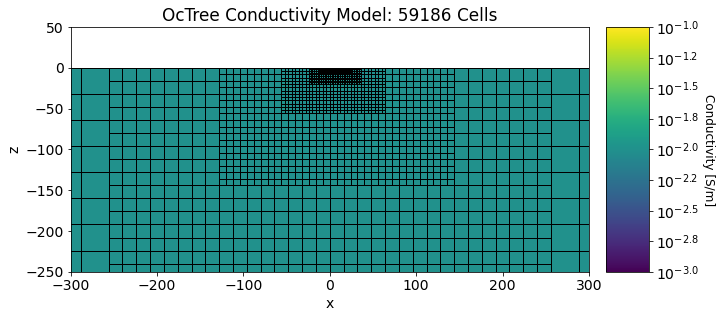

In [5]:
fig = plt.figure(figsize=(12,4))
ind_active = mesh.cell_centers[:, 2] < 0
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
log_model = np.log10(sigma_model[ind_active])

ax1 = fig.add_axes([0.14, 0.1, 0.6, 0.85])
mesh.plot_slice(
    plotting_map * log_model, normal="Y", ax=ax1, ind=int(mesh.hy.size / 2),
    clim=(-3, -1), grid=True
)

ax1.set_xlim([-300, 300])
ax1.set_ylim([-250, 50])
ax1.set_title("OcTree Conductivity Model: {} Cells".format(mesh.nC))

ax2 = fig.add_axes([0.76, 0.1, 0.05, 0.85])
norm = mpl.colors.Normalize(vmin=-3, vmax=-1)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

And here we plot the susceptibility model.

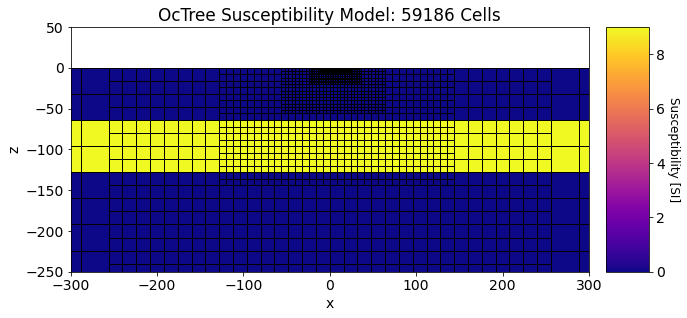

In [6]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_axes([0.14, 0.1, 0.6, 0.85])
mesh.plot_slice(
    plotting_map * chi_model[ind_active],
    normal="Y", ax=ax1, ind=int(mesh.hy.size / 2), clim=(np.min(chi_model), np.max(chi_model)),
    grid=True, pcolor_opts={'cmap':'plasma'}
)

ax1.set_xlim([-300, 300])
ax1.set_ylim([-250, 50])
ax1.set_title("OcTree Susceptibility Model: {} Cells".format(mesh.nC))

ax2 = fig.add_axes([0.76, 0.1, 0.05, 0.85])
norm = mpl.colors.Normalize(vmin=np.min(chi_model), vmax=np.max(chi_model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical", cmap=mpl.cm.plasma)
cbar.set_label("Susceptibility [SI]", rotation=270, labelpad=15, size=12)

Here we define the forward simulation.

In [7]:
sigma_map = maps.IdentityMap(nP=mesh.nC)

simulation = tdem.simulation.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=sigma_map, solver=Pardiso
)

mu0 = 4*np.pi*1e-7
mu_model = mu0 * (1 + chi_model)
simulation.mu = mu_model

time_steps = time_steps = [(5e-07, 40), (2.5e-06, 40), (1e-5, 40), (5e-5, 40), (2.5e-4, 40)]
simulation.time_steps = time_steps

D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:247: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


Finally, we predict the secondary magnetic field data for the model provided.

In [8]:
dpred = simulation.dpred(sigma_model)
dpred = dpred.reshape((3, 6, len(times)))
dpred = [dpred[ii, :, :].T for ii in range(0, 3)]

D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh.edgeCurl has been deprecated, please use TreeMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh.faceDiv has been deprecated, please use TreeMesh.face_divergence. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
D:\Documents\Repositories\discretize\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.getFaceInnerProduct has been deprecated, please use TreeMesh.get_face_inner_product. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
D:\Documents\Repositories\discretize\discretize\operators\inner_products.py:48: FutureWarning: The invMat keyword argument has been deprecated, please use invert_matrix. This will be removed in discretize 1.0.0
  warnings.warn(
D:\Documents\Repositories\discr

If desired, we can export the data to a simple text file.

In [9]:
if write_output:
    
    fname_analytic = rootdir + 'dpred_octree.txt'
    
    header = 'TIME HX HY HZ DBDTX DBDTY DBDTZ'
    
    t_column = np.kron(np.ones(3), times)
    dpred_out = np.c_[t_column, np.vstack(dpred)]

    fid = open(fname_analytic, 'w')
    np.savetxt(fid, dpred_out, fmt='%.6e', delimiter=' ', header=header)
    fid.close()

## Plotting Simulated Data

Here, we plot the H and dB/dt data for horizontal coaxial, horizontal coplanar and vertical coplanar geometries.

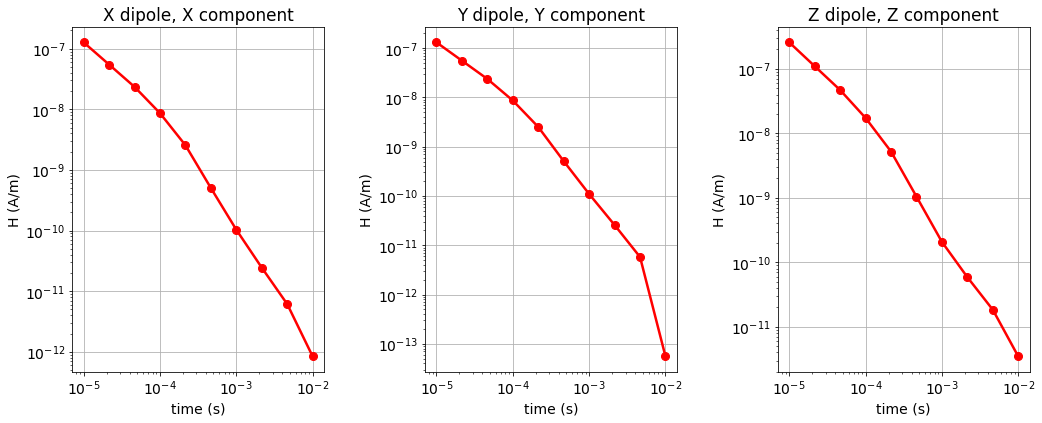

In [10]:
fig = plt.figure(figsize=(14, 6))
lw = 2.5
ms = 8

ax1 = 3*[None]

for ii, comp in enumerate(['X','Y','Z']):

    ax1[ii] = fig.add_axes([0.05+0.35*ii, 0.1, 0.25, 0.8])
    ax1[ii].loglog(times, dpred[ii][:, ii], 'r-o', lw=lw, markersize=8)
    ax1[ii].set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
    ax1[ii].grid()
    ax1[ii].set_xlabel('time (s)')
    ax1[ii].set_ylabel('H (A/m)'.format(comp))
    ax1[ii].set_title(comp + ' dipole, ' + comp + ' component')

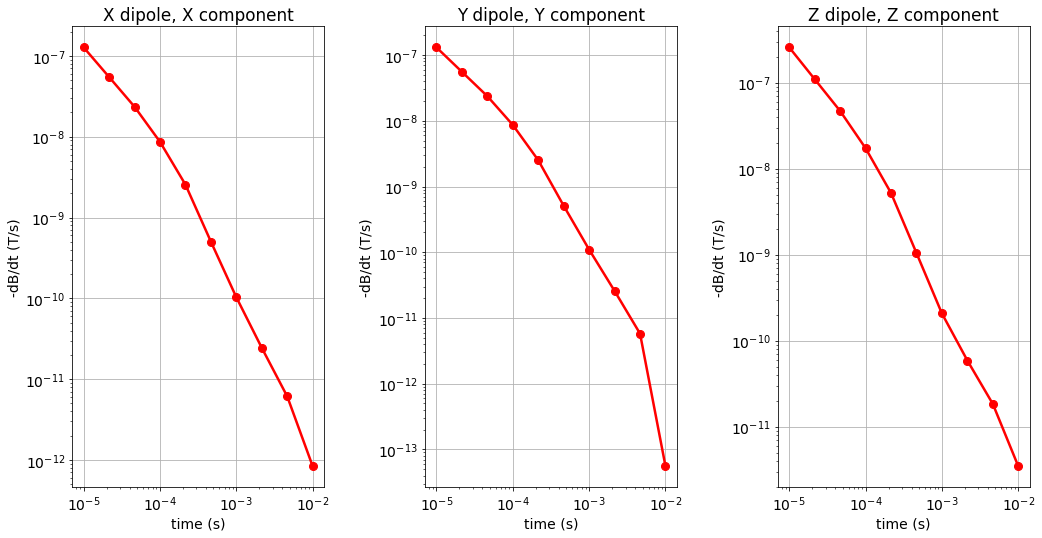

In [11]:
fig = plt.figure(figsize=(14, 8))
lw = 2.5
ms = 8

ax1 = 3*[None]

for ii, comp in enumerate(['X','Y','Z']):

    ax1[ii] = fig.add_axes([0.05+0.35*ii, 0.1, 0.25, 0.8])
    ax1[ii].loglog(times, dpred[ii][:, ii], 'r-o', lw=lw, markersize=8)
    ax1[ii].set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
    ax1[ii].grid()
    ax1[ii].set_xlabel('time (s)')
    ax1[ii].set_ylabel('-dB/dt (T/s)'.format(comp))
    ax1[ii].set_title(comp + ' dipole, ' + comp + ' component')